In [249]:
# Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [250]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Analizaremos los datos de Información Estadística Climatológica del Servico Meteorológico Nacional 
# de CONAGUA que podemos descargar del sitio:
# (https://smn.conagua.gob.mx/es/climatologia/informacion-climatologica/informacion-estadistica-climatologica) 

# Tomar la dirección URL del archivo en formato 'raw'
# url = 'https://raw.githubusercontent.com/MarioGHdz/FisicaComputacional1/master/Actividad%201/Datos%20diarios.txt'
url = 'https://raw.githubusercontent.com/MarioGHdz/FisicaComputacional1/master/Actividad%201/Datos%20diarios.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2018)]

# Estas 3 colecciones serán nuestras Series de Tiempo (DataFrames) para el análisis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16499 entries, 1969-05-01 to 2016-04-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  16498 non-null  float64
 1   Evap    11586 non-null  float64
 2   Tmax    16465 non-null  float64
 3   Tmin    16467 non-null  float64
 4   Año     16499 non-null  int64  
 5   Mes     16499 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 902.3+ KB


Definimos una función para probar la Estacionaridad de una Serie de Tiempo usando la **Prueba Aumentada de Dickey-Fuller(ADF)**

In [251]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [252]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la época de 1990 a 2017 
# o el periodo que se desee. Podemos regresar a este punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2014-03', '2016-07'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2014-03-01,27.0,NaN,19.0,7.0,2014,Mar
2014-03-02,0.0,NaN,21.0,8.0,2014,Mar
2014-03-03,0.0,NaN,23.0,7.0,2014,Mar
2014-03-04,0.0,NaN,24.0,7.0,2014,Mar
2014-03-05,0.0,NaN,28.0,8.0,2014,Mar


In [253]:
# Vemos su encabezado
ts_90['Tmax'].head()

Fecha
2014-03-01    19.0
2014-03-02    21.0
2014-03-03    23.0
2014-03-04    24.0
2014-03-05    28.0
Name: Tmax, dtype: float64

In [254]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico

ts_test = ts_90['Tmax'].copy()

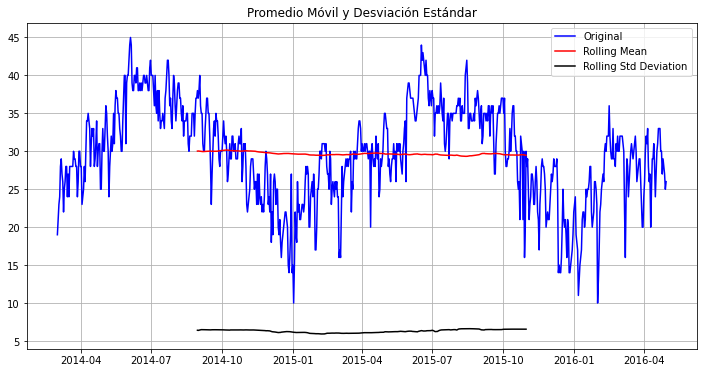

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -2.571830
p-value                          0.098960
#Lags Used                      10.000000
Number of Observations Used    781.000000
Critical Value (1%)             -3.438751
Critical Value (5%)             -2.865248
Critical Value (10%)            -2.568744
dtype: float64


In [255]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test)

El valor p < 0.05, es decir que podemos rechazar la hipótesis nula de que la serie de tiempo no es estacionaria y afirmar que la serie de tiempo es estacionaria con 99% de confianza. (Hay que jugar con el parámetro 'halflife', en este caso se usaron 30 días).

Podemos decir que la serie es estacionaria, pues tanto el promedio móvil exponencial y la desviación estandar son constantes.

Ahora vamos a trabajar con la estacionalidad (variaciones debido a las estaciones del año)

Existen dos métodos para eliminar la Estacionalidad:

* Diferenciación discreta (calcular diferencias involucrando un corrimiento 'shift()')
* Descomposición (Tendencia + Estacionalidad + Residuo) - lo vimos en la actividad pasada.

# **Solo usar cuando el valor de p sea menor a 0.05**


Notamos que el promedio móvil no es constante y el valor p de ADF: p > 0.05 (0.0876).

La tendencia y la estacionalidad hacen que una serie no sea estacionaria.

Primero trabajaremos para lograr que la Tendencia sea constante.

Hay muchas formas para reducir la tendencia. Es hacer cambio de escalas: log(x), sqrt(x), raiz_cúbica(x),... la idea es disminuir la tendencia para valores grandes de x.

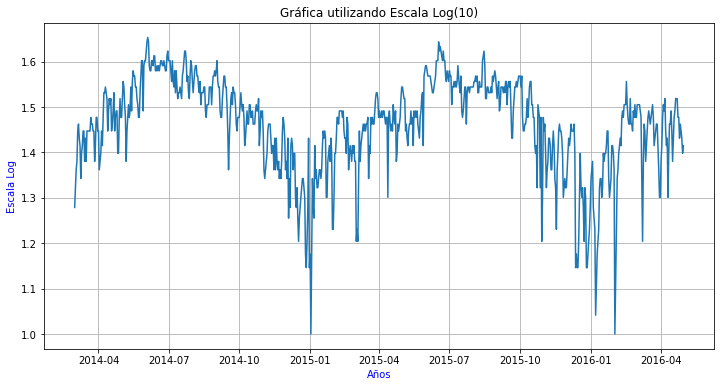

In [256]:
#Usar para reducir el valor de p, así hasta que sea menor que 0.05
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

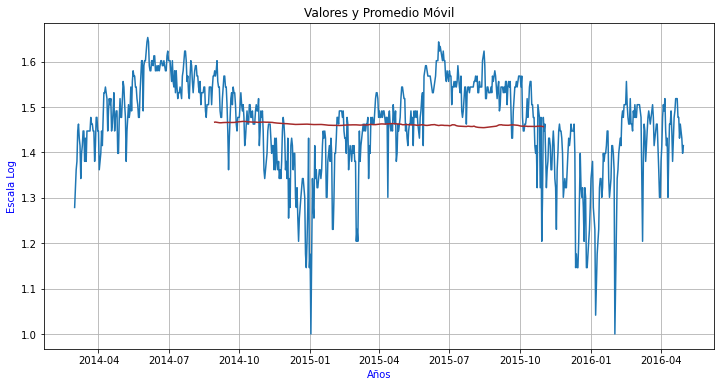

In [257]:
moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [258]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
2014-03-01   NaN
2014-03-02   NaN
2014-03-03   NaN
2014-03-04   NaN
2014-03-05   NaN
Name: Tmax, dtype: float64

In [259]:
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
2014-08-30    0.113199
2014-08-31    0.101339
2014-09-01    0.113245
2014-09-02    0.135881
2014-09-03    0.090606
Name: Tmax, dtype: float64

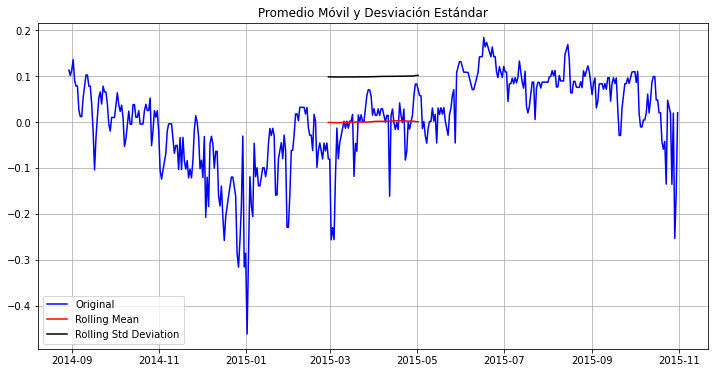

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -2.879898
p-value                          0.047736
#Lags Used                       5.000000
Number of Observations Used    422.000000
Critical Value (1%)             -3.445941
Critical Value (5%)             -2.868413
Critical Value (10%)            -2.570431
dtype: float64


In [260]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff)

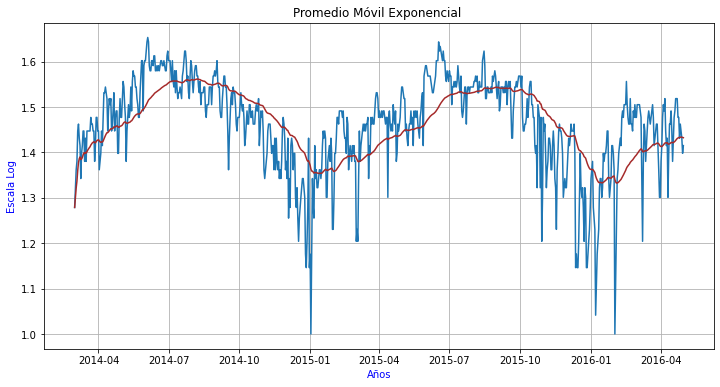

In [261]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [262]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg

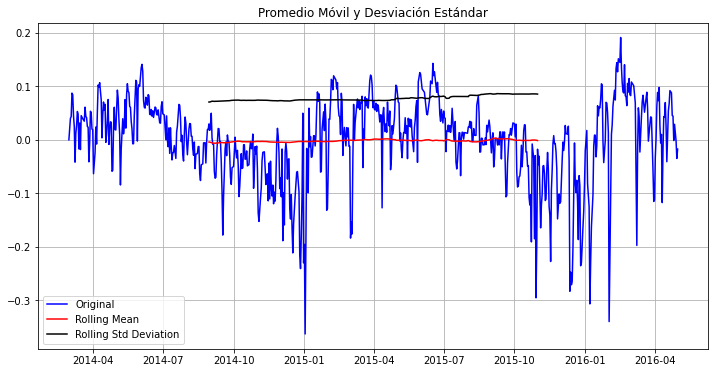

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -3.938753
p-value                          0.001767
#Lags Used                      10.000000
Number of Observations Used    781.000000
Critical Value (1%)             -3.438751
Critical Value (5%)             -2.865248
Critical Value (10%)            -2.568744
dtype: float64


In [263]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff)

# **Continuación**

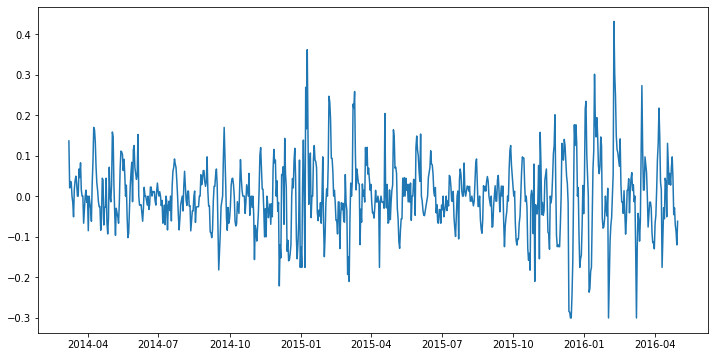

In [264]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);


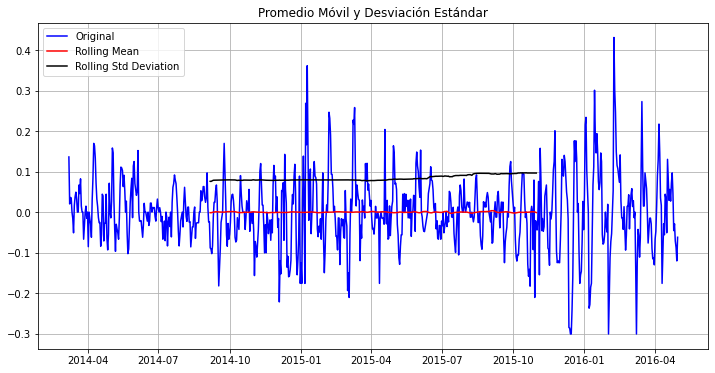

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.373982e+00
p-value                        2.307971e-08
#Lags Used                     2.100000e+01
Number of Observations Used    7.630000e+02
Critical Value (1%)           -3.438950e+00
Critical Value (5%)           -2.865335e+00
Critical Value (10%)          -2.568791e+00
dtype: float64


In [265]:
# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

In [266]:
# Número de datos utilizados
len(ts_test_log_diff)

785

Podemos decir que es estacionaria, el valor p < 0.05 y la desviación estándar no varía mucho.

Pero la estacionalidad domina.

Veamos el siguiente ***método de descomposición*** que utilzamos en la actividad anterior.

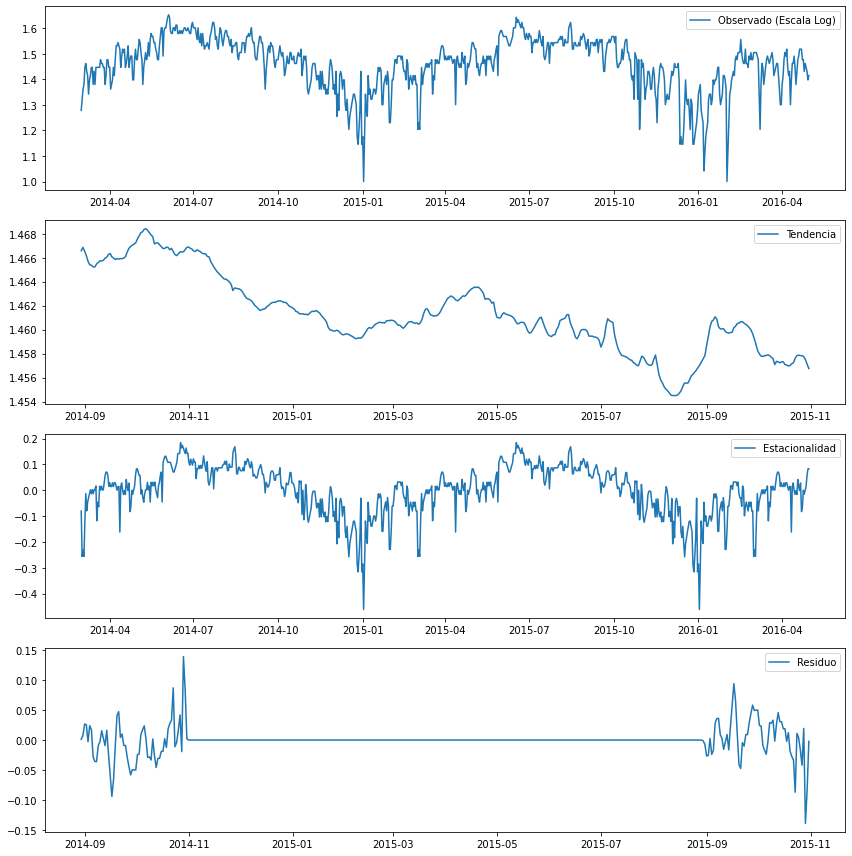

In [267]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

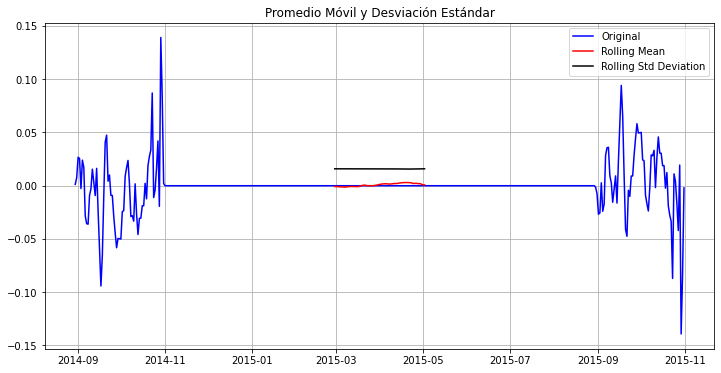

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -3.576976
p-value                          0.006217
#Lags Used                      16.000000
Number of Observations Used    411.000000
Critical Value (1%)             -3.446361
Critical Value (5%)             -2.868598
Critical Value (10%)            -2.570530
dtype: float64


In [268]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)


Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (4.86 x 10^(-14)). Podemos afirmar que ***es una serie de tiempo estacionaria con mas de un 99% de confianza.***

# Prueba Aumentada de Dickey-Fuller(ADF) para Tmin


# **Aclaraciones:**
Para el modelado de la Temperatura mínima, no se pudo realizar debido a los siguientes factores:

*   Falta de datos. Se realizó el modelado en diversos periodos (1970 - en adelante), notandosé diversos huecos en los datos, lo cual pasaba regularmente. Dandosé una falta de muestra para el modelado de ADF.
*   Hubo problemas en cuanto la compatibilidad de datos de la Temperatura Máxima y Mínima (si en una se lograba en el otro no).

Por lo tanto solo se trabajo para la Temperatura Máxima, aun así se realizó el código para la Temperatura Mínima.



In [269]:
# Definimos la Serie de Tiempo con Tmin que vamos a estudiar, le damos un nombre genérico

ts_test2 = ts_90['Tmin'].copy()

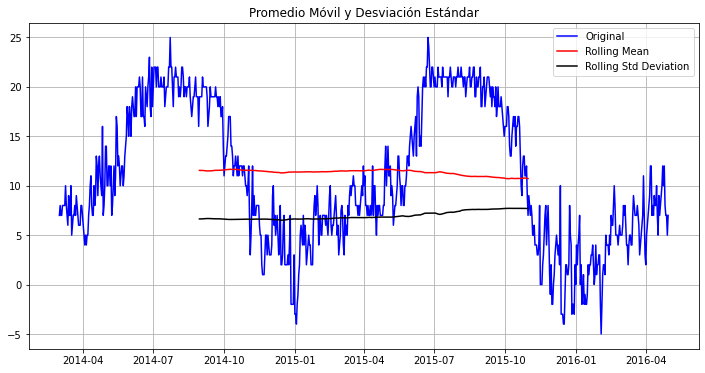

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -1.284561
p-value                          0.636206
#Lags Used                      12.000000
Number of Observations Used    779.000000
Critical Value (1%)             -3.438772
Critical Value (5%)             -2.865257
Critical Value (10%)            -2.568749
dtype: float64


In [270]:
# Realizamos la Prueba de Estacionaridad de Tmin
test_stationarity(ts_test2)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


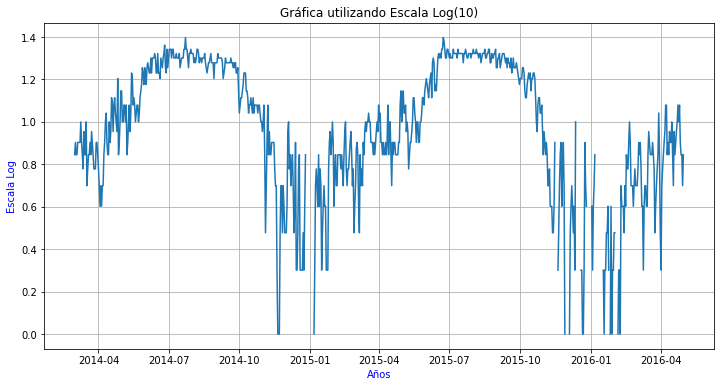

In [271]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test2_log= np.log10(ts_test2)
plt.plot(ts_test2_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

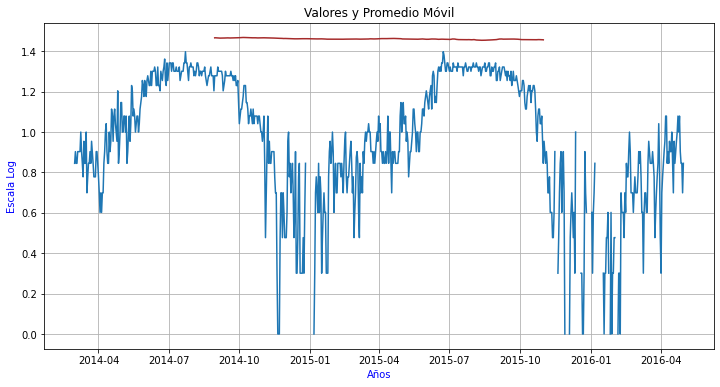

In [272]:
moving2_avg = ts_test2_log.rolling(365, center=True).mean()
plt.plot(ts_test2_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [273]:
ts_test2_log_moving2_ave_diff = ts_test2_log - moving2_avg 
ts_test2_log_moving2_ave_diff.head()

Fecha
2014-03-01   NaN
2014-03-02   NaN
2014-03-03   NaN
2014-03-04   NaN
2014-03-05   NaN
Name: Tmin, dtype: float64

In [274]:
ts_test2_log_moving2_ave_diff.dropna(inplace=True)
ts_test2_log_moving2_ave_diff.head()

Series([], Name: Tmin, dtype: float64)

In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test2_log_moving2_ave_diff)

In [ ]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test2_log.ewm(halflife=30).mean()
plt.plot(ts_test2_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [ ]:
EWM_avg.head()

In [ ]:
# Probamos la estacionarida de la diferencia 
ts_test2_log_EWM_avg_diff = ts_test2_log - EWM_avg

In [ ]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test2_log_EWM_avg_diff)

In [ ]:
# Diferenciamos usando la función df.shift()
ts_test2_log_diff = ts_test2_log - ts_test2_log.shift(periods=7)
plt.plot(ts_test2_log_diff);

In [ ]:
# Probamos la estacionaridad
ts_test2_log_diff.dropna(inplace=True)
test_stationarity(ts_test2_log_diff)

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test2_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test2_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

# Pronóstico de Series de Tiempo
Ya que hemos obtenido una serie de tiempo estacionaria, construiremos un modelo utilizando diferenciación, porque es fácil añadir el error, la tendencia y la estacionalidad a las predicciones.

Utilizaremos el ***método ARIMA***.

Necesitamos agregar las siguientes 2 líneas en la celda 1, donde cargamos las bibliotecas a la memoria de trabajo.

from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.stattools import acf, pacf

Usaremos propiedades de la Distribución Normal centrada en el promedio y std dev=1, donde el 95% de los datos caen entre -1.96 y 1.96.



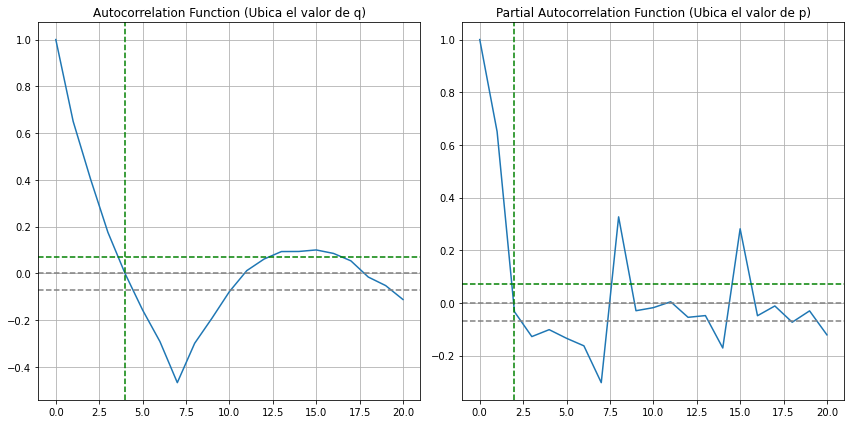

In [277]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()


Las líneas punteadas alrededor de cero representan los intervalos de confianza y nos serviran para determinar los valores p y q del modelo ARIMA.

p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.

q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.

Con estos dos valores construiremos los modelos ARIMA correspondientes.

# **Modelo AR (Auto-Regresión)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                  791
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1241.095
Method:                       css-mle   S.D. of innovations              0.050
Date:                Mon, 22 Feb 2021   AIC                          -2474.189
Time:                        01:21:56   BIC                          -2455.496
Sample:                    03-02-2014   HQIC                         -2467.004
                         - 04-30-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.001      0.108      0.914      -0.003       0.003
ar.L1.D.Tmax    -0.1473      0.035     -4.160      0.000      -0.217      -0.078
ar.L2.D.Tmax    -0.0890      0.035     -2.51

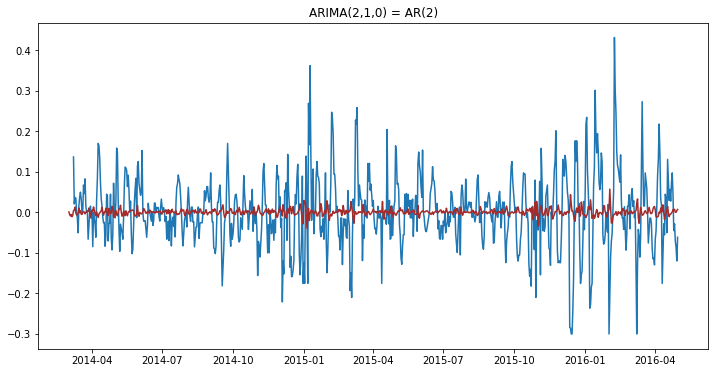

In [278]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

# **Modelo MA (Promedio Móvil)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                  791
Model:                 ARIMA(0, 1, 4)   Log Likelihood                1279.821
Method:                       css-mle   S.D. of innovations              0.048
Date:                Mon, 22 Feb 2021   AIC                          -2547.642
Time:                        01:21:56   BIC                          -2519.603
Sample:                    03-02-2014   HQIC                         -2536.865
                         - 04-30-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.018e-05      0.000      0.201      0.841      -0.001       0.001
ma.L1.D.Tmax    -0.2577      0.035     -7.333      0.000      -0.327      -0.189
ma.L2.D.Tmax    -0.1694      0.035     -4.81

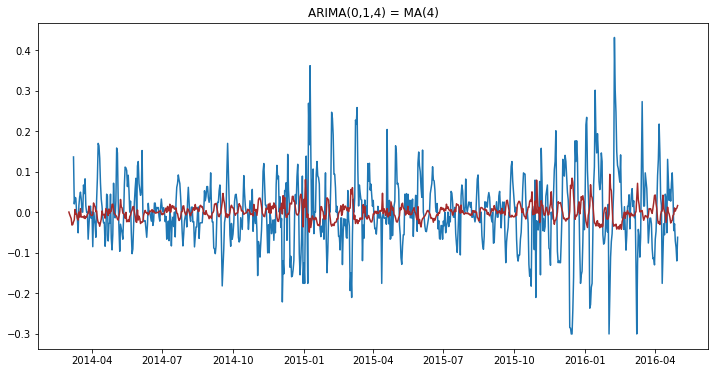

In [279]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

# **Modelo ARIMA (Auto-Regresión + Promedio Móvil)**

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                  791
Model:                 ARIMA(2, 1, 4)   Log Likelihood                1281.865
Method:                       css-mle   S.D. of innovations              0.048
Date:                Mon, 22 Feb 2021   AIC                          -2547.731
Time:                        01:21:59   BIC                          -2510.344
Sample:                    03-02-2014   HQIC                         -2533.361
                         - 04-30-2016                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.886e-05      0.000      0.208      0.835      -0.001       0.001
ar.L1.D.Tmax     1.3412      0.212      6.337      0.000       0.926       1.756
ar.L2.D.Tmax    -0.4951      0.110     -4.49

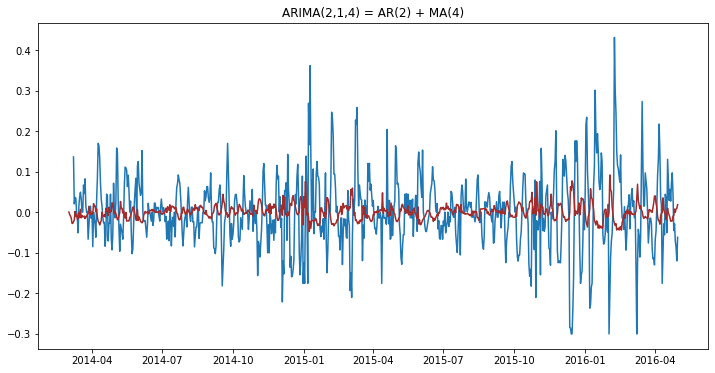

In [280]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())


El Criterio de Información de Akaike (AIC), como indicador del mejor modelo ARIMA.

El criterio AIC se basa en dos principios:

* Bondad del ajuste
* Simplicidad del modelo o principio de parsimonia.

Aquel modelo que tenga el menor AIC, y los valores más pequeños de (p,d,q) se selecciona como el mejor modelo de ajuste.

Cuando imprimimos los resúmenes de los modelos con la función results.summary(), nos regresa una serie de valores y parámetros.

Entre ellos se encuentra el criterio AIC.

ARIMA(2,1,0): AIC = -8286.534

ARIMA(0,1,4): AIC = -8465.088

**ARIMA(2,1,4): AIC = -8469.635 <- Es el menor AIC**

Podemos afirmar que **ARIMA(2,1,4) es el mejor modelo** de los 3 que exploramos.

Último paso: Recolectando todo y regresando a la escala original.

Pasos a seguir:

* Obtener los valores de la predicción y convertirlos en serie. 
* Observaremos que falta un valor en el inicio (usamos shift=1).
Luego convertir la diferenciación a escala logarímica

In [281]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2014-03-02    0.000099
2014-03-03   -0.005778
2014-03-04   -0.009611
2014-03-05   -0.013960
2014-03-06   -0.027479
                ...   
2016-04-26    0.007340
2016-04-27   -0.000629
2016-04-28    0.007789
2016-04-29    0.009504
2016-04-30    0.018348
Length: 791, dtype: float64


In [282]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())


Fecha
2014-03-01         NaN
2014-03-02    1.322318
2014-03-03    1.355950
2014-03-04    1.370600
2014-03-05    1.433198
dtype: float64
Fecha
2016-04-26    1.469738
2016-04-27    1.446529
2016-04-28    1.439153
2016-04-29    1.407444
2016-04-30    1.433321
dtype: float64



El siguiente paso estomar el anti-logaritmo de log(Tmax), i.e. usamos la función 10**log(Tmax).

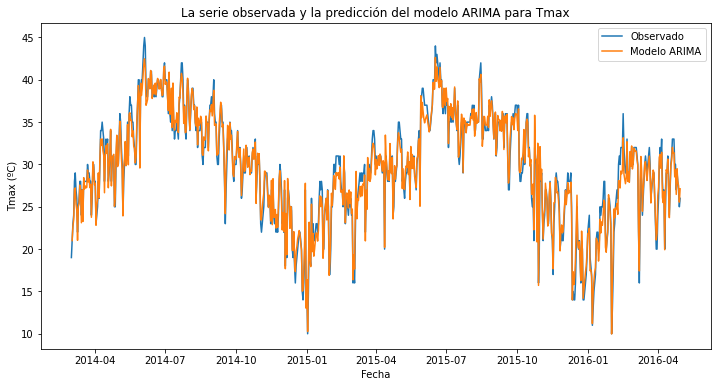

In [283]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [284]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 1.0710367180760343


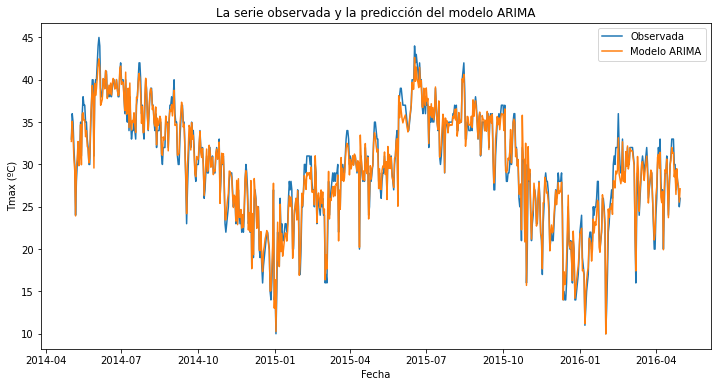

In [285]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

# **Modelo ARIMA Tmin**

In [ ]:
# Aplicamos ARIMA

lag_acf = acf(ts_test2_log_diff, nlags=20)
lag_pacf = pacf(ts_test2_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test2_log, order=(2,1,0), missing='drop')
results_AR2 = model.fit(displ=-1)
plt.plot(ts_test2_log_diff)
plt.plot(results_AR2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR2.summary())

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test2_log, order=(0,1,4), missing='drop')
results_MA2 = model.fit(displ=-1)
plt.plot(ts_test2_log_diff)
plt.plot(results_MA2.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA2.summary())

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test2_log, order=(2,1,4), missing='drop')
results_ARIMA2 = model.fit(displ=-1)
plt.plot(ts_test2_log_diff)
plt.plot(results_ARIMA2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA2.summary())

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA2_diff = pd.Series(results_ARIMA2.fittedvalues, copy=True)
print(predictions_ARIMA2_diff)

In [ ]:

# Le sumamos las predicciones de ARIMA a la serie observada (ts_test2_log)
predictions_ARIMA2_log = pd.Series(ts_test2_log, index = ts_test2_log.index)
predictions_ARIMA2_log = predictions_ARIMA2_log.add(predictions2_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA2 = 10**(predictions_ARIMA2_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test2, label='Observado');
plt.plot(predictions_ARIMA2, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA2 - ts_test2)**2))
print('RMSE:', RMSE)

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test2_last = ts_test.tail(730)
predictions_ARIMA2_last = predictions_ARIMA2.tail(730)
plt.plot(ts_test2_last, label='Observada');
plt.plot(predictions_ARIMA2_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');
